In [117]:
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
start_time = time.time()

import xobjects as xo
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

# import apertls
from matplotlib.colors import LogNorm

import gzip
from typing import Union

import awkward as ak
import pandas as pd
import re
from datetime import datetime

# BPM classes orbit data 
I addapted it to be formatted the same as the post mortem, the only difference being the _build_full_index because the intitial file does not give the same information as post-mortem files

In [ ]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):
    @property
    def full_index(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        return self._full_index
    
    @property
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        return self._bpms_hor
    
    @property
    def bpms_ver(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        return self._bpms_ver
    
    @property
    def hor_turn_position(self):
        if not hasattr(self, '_hor_pos'):
            self._build_hor_pos()
        return self._hor_pos
    
    @property
    def ver_turn_position(self):
        if not hasattr(self, '_ver_pos'):
            self._build_ver_pos()
        return self._ver_pos
    
    def _build_full_index(self):
        self._full_index = {}
        bpm_entries = []

        for i, bpm in enumerate(self.name):
            bpm_entries.append({
                        'bpm_name': bpm,
                        'plane': self.plane[i],
                        'position': self.position[i]
                    })
        
         # Sort BPMs by natural order (e.g., bpm.1, bpm.2, ..., bpm.10)
        def natural_key(entry):
            # Extract the numeric part of the BPM name for sorting
            match = re.search(r'(\d+)$', entry['bpm_name'])
            return int(match.group(1)) if match else entry['bpm_name']

        bpm_entries.sort(key=natural_key)

        # Build _full_index with sorted BPMs
        for idx, entry in enumerate(bpm_entries):
            name = entry['bpm_name']
            if name not in self._full_index:
                self._full_index[name] = {}
            self._full_index[name]['plane'] = entry['plane']
            self._full_index[name]['index'] = idx
            self._full_index[name]['positions'] = entry['position']
    
    def _build_index(self):
        self._index = {}
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        for i, bpm in enumerate(self._full_index):
            if bpm not in self._index:
                self._index[bpm] = i

    def _build_bpms_hor(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'H']
        self._bpms_hor = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    def _build_bpms_ver(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'V']
        self._bpms_ver = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index

    def _build_hor_pos(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        self._hor_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_hor])
    
    def _build_ver_pos(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        self._ver_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_ver])

class CorrectorsCollectionBehavior(ak.Array):
    # @property
    # def correctors_hor(self):
    #     if not hasattr(self, '_correctors_hor'):
    #         self._build_correctors_hor()
    #     return self._correctors_hor

    # @property
    # def correctors_ver(self):
    #     if not hasattr(self, '_correctors_ver'):
    #         self._build_correctors_ver()
    #     return self._correctors_ver

    # @property
    # def hor_kick(self):
    #     if not hasattr(self, '_hor_kick'):
    #         self._build_hor_kick()
    #     return self._hor_kick
    # @property
    # def ver_kick(self):
    #     if not hasattr(self, '_ver_kick'):
    #         self._build_ver_kick()
    #     return self._ver_kick
    
    # def _build_correctors_hor(self):
    #     self._correctors_hor = self[self.plane == 'H']

    # def _build_correctors_ver(self):
    #     self._correctors_ver = self[self.plane == 'V']
    
    # def _build_hor_kick(self):
    #     if not hasattr(self, '_correctors_hor'):
    #         self._build_correctors_hor()
    #     self._hor_kick = ak.Array([self.kick for corrector in self._correctors_hor])


    # def _build_ver_kick(self):
    #     if not hasattr(self, '_correctors_ver'):
    #         self._build_correctors_ver()
    #     self._ver_kick = ak.Array([self.kick for corrector in self._correctors_ver])
    pass
ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior
ak.behavior["*", "CorrectorsCollection"] = CorrectorsCollectionBehavior

In [68]:
def load_bpm_file_data(path: Union[str, Path]) -> ak.Array:
    """
    Load a .data or .data.gz file into an Awkward Array with BPMCollection behavior.
    """

    #file opening with different compression
    path = Path(path)
    opener = gzip.open if path.suffix == ".gz" else open
    with opener(path, "rt") as f:
        lines = f.readlines()

    #Sections of file
    header_lines = []
    orbit_lines = []
    corrector_lines = []

    mode = "header"
    for line in lines:
        if line.startswith("# MONITOR"):
            mode = "orbit"
            continue
        elif line.startswith("# CORRECTOR"):
            mode = "corrector"
            continue

        if mode == "header":
            header_lines.append(line)
        elif mode == "orbit":
            if not line.startswith('*'):
                orbit_lines.append(line)
        elif mode == "corrector":
            if not line.startswith('*'):
                corrector_lines.append(line)

    #Metadata
    meta = {}  # <-- parse @ DATE, @ DPP, etc.
    for line in header_lines:
        if not line.startswith('@'):
            continue
        parts = line.strip().split(maxsplit=3)
        if len(parts) < 4:
            continue
        _, key, dtype, value = parts
        if dtype == "%d":
            value = int(value)
        elif dtype == "%f":
            value = float(value)
        elif dtype == "%s":
            value = value.strip('"')
        meta[key] = ak.Array([value])
    
    
    #Orbit
    orbit = {
        "name": [], "plane": [], "beam": [], "position": [],
        "rms": [], "sum": [], 'hw-status': [], 'status' : [], "status_tag": [],
    }
    # Fill orbit[...] from orbit_lines
    for line in orbit_lines:
        parts = line.strip().split(maxsplit=9)
        assert len(parts)==9
        for i, key in enumerate(list(orbit.keys())):
            value = parts[i]
            # Simple type inference
            try:
                if "." in value:
                    orbit[key].append(float(value))
                else:
                    orbit[key].append(int(value))
            except ValueError:
                if key == 'name':
                    orbit[key].append(value.lower())
                else:
                    orbit[key].append(value)
    
    for key in orbit:
        orbit[key]=ak.Array(orbit[key])
    
    #Correctors
    correctors = {
        "name": [], "plane": [], "beam": [], 'strength_name' : [], "kick": [], "rt_kick": [],
    }
    # Fill correctors[...] from corrector_lines
    for line in corrector_lines:
        parts = line.strip().split(maxsplit=6)
        assert len(parts)==6
        for i, key in enumerate(list(correctors.keys())):
            value = parts[i]
            # Simple type inference
            try:
                if "." in value:
                    correctors[key].append(float(value))
                else:
                    correctors[key].append(int(value))
            except ValueError:
                if key=='name':
                    correctors[key].append(value.lower())
                else:
                    correctors[key].append(value)
    
    for key in correctors:
        correctors[key]=ak.Array(correctors[key])

    #Total dictionary data, idk how to make awkward array out of it
    data = {
        "orbit": ak.Array(orbit, with_name='BPMCollection'),
        "correctors": ak.Array(correctors, with_name='CorrectorsCollection'),
        "meta": ak.Array(meta),
    }

    return data


In [71]:
test_file = load_bpm_file_data('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_18-01-46_MD5_CY34_TR0.data.gz')

# BPM classes post mortem

In [161]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):
    @property
    def full_index(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        return self._full_index
    
    @property
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        return self._bpms_hor
    
    @property
    def bpms_ver(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        return self._bpms_ver
    
    @property
    def hor_turn_position(self):
        if not hasattr(self, '_hor_pos'):
            self._build_hor_pos()
        return self._hor_pos
    
    @property
    def ver_turn_position(self):
        if not hasattr(self, '_ver_pos'):
            self._build_ver_pos()
        return self._ver_pos
    
    def _build_full_index(self):
        self._full_index = {}

        bpm_entries = []

        # Collect all BPMs with metadata
        for crate in self.fields:
            for i, bpm in enumerate(self[crate]['value']['channelNames'][0]):
                if bpm != 'SPARE':
                    split_bpm = bpm.split('.')
                    bpm_name = split_bpm[0].lower() + '.' + split_bpm[1]
                    plane = split_bpm[2]
                    position = self[crate]['value']['positions'][0][i]

                    bpm_entries.append({
                        'bpm_name': bpm_name,
                        'plane': plane,
                        'crate': crate,
                        'position': position
                    })

        # Sort BPMs by natural order (e.g., bpm.1, bpm.2, ..., bpm.10)
        def natural_key(entry):
            # Extract the numeric part of the BPM name for sorting
            match = re.search(r'(\d+)$', entry['bpm_name'])
            return int(match.group(1)) if match else entry['bpm_name']

        bpm_entries.sort(key=natural_key)

        # Build _full_index with sorted BPMs
        for idx, entry in enumerate(bpm_entries):
            name = entry['bpm_name']
            if name not in self._full_index:
                self._full_index[name] = {}
            self._full_index[name]['plane'] = entry['plane']
            self._full_index[name]['index'] = idx
            self._full_index[name]['crate'] = entry['crate']
            self._full_index[name]['positions'] = entry['position']
    
    def _build_index(self):
        self._index = {}
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        for i, bpm in enumerate(self._full_index):
            if bpm not in self._index:
                self._index[bpm] = i

    def _build_bpms_hor(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'H']
        self._bpms_hor = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    def _build_bpms_ver(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'V']
        self._bpms_ver = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index

    def _build_hor_pos(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        self._hor_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_hor])
    
    def _build_ver_pos(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        self._ver_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_ver])


ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior

# Plotting cycles MD 30/04/2025

In [ ]:
def get_timestamp(file_path):
    filename = file_path.stem.split('.')[0]
    # Extract the date-time string using regex
    match = re.search(r'\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}', filename)
    if match:
        datetime_str = match.group(0)
        # Parse it into a datetime object
        timestamp = datetime.strptime(datetime_str, "%Y-%m-%d_%H-%M-%S")
        return timestamp
    else:
        print(f"No valid timestamp found in {file_path}")
        return None

## Radial steering

In [129]:
files_to_load = [Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-07-04_MD5_CY5_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-08-39_MD5_CY8_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-08-54_MD5_CY9_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-09-21_MD5_CY10_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-10-16_MD5_CY12_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-12-07_MD5_CY16_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-12-34_MD5_CY17_TR0.data.gz')]

In [130]:
bpm_dict = {}
for file in files_to_load:
    ts = get_timestamp(file)
    if ts:
        bpm_dict[ts] = load_bpm_file_data(file)['orbit']

In [110]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
tt = line.get_table()
s_positions_bpms = np.array([line.get_s_position(f'{bpm_dict[ts].bpms_hor[i]}..0') for i in range(len(bpm_dict[ts].bpms_hor))] if ts in bpm_dict else [])

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


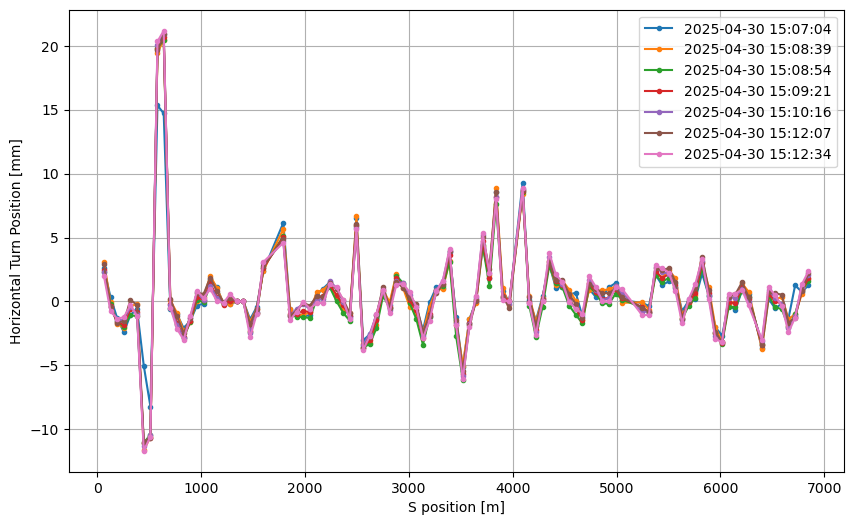

In [116]:
fig, ax = plt.subplots(figsize=(10, 6))
for ts in bpm_dict:
    ax.plot(s_positions_bpms[:-1], bpm_dict[ts].hor_turn_position[:-1]*1e-3, label=ts.strftime('%Y-%m-%d %H:%M:%S'), marker='o', markersize=3, linestyle='-')
ax.set_xlabel('S position [m]')
ax.set_ylabel('Horizontal Turn Position [mm]')
ax.grid()
ax.legend()

## Betatron lossmap

In [126]:
files_to_load = [Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_14-59-42_MD5_CY12_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-00-37_MD5_CY14_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-01-05_MD5_CY1_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-01-32_MD5_CY2_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-02-00_MD5_CY3_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-02-27_MD5_CY4_TR0.data.gz')]

In [127]:
bpm_dict = {}
for file in files_to_load:
    ts = get_timestamp(file)
    if ts:
        bpm_dict[ts] = load_bpm_file_data(file)['orbit']

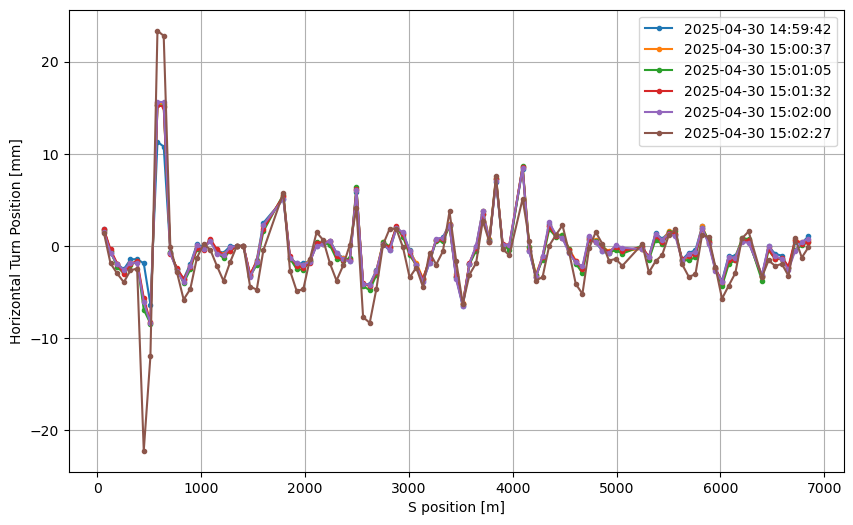

In [128]:
fig, ax = plt.subplots(figsize=(10, 6))
for ts in bpm_dict:
    ax.plot(s_positions_bpms[:-1], bpm_dict[ts].hor_turn_position[:-1]*1e-3, label=ts.strftime('%Y-%m-%d %H:%M:%S'), marker='o', markersize=3, linestyle='-')
ax.set_xlabel('S position [m]')
ax.set_ylabel('Horizontal Turn Position [mm]')
ax.grid()
ax.legend()

## All

In [131]:
files_to_load = [Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-07-04_MD5_CY5_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-08-39_MD5_CY8_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-08-54_MD5_CY9_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-09-21_MD5_CY10_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-10-16_MD5_CY12_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-12-07_MD5_CY16_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-12-34_MD5_CY17_TR0.data.gz')]

bpm_dict = {}
for file in files_to_load:
    ts = get_timestamp(file)
    if ts:
        bpm_dict[ts] = load_bpm_file_data(file)['orbit']

files_to_load = [Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_14-59-42_MD5_CY12_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-00-37_MD5_CY14_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-01-05_MD5_CY1_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-01-32_MD5_CY2_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-02-00_MD5_CY3_TR0.data.gz'),
                 Path('../../MD_data/20250430/ORBIT_SPSRING_2025-04-30_15-02-27_MD5_CY4_TR0.data.gz')]

for file in files_to_load:
    ts = get_timestamp(file)
    if ts:
        bpm_dict[ts] = load_bpm_file_data(file)['orbit']

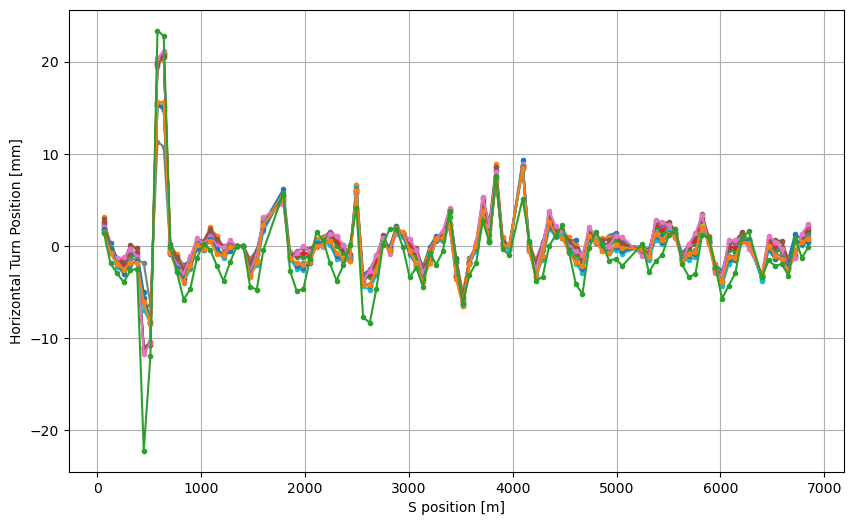

In [133]:
fig, ax = plt.subplots(figsize=(10, 6))
for ts in bpm_dict:
    ax.plot(s_positions_bpms[:-1], bpm_dict[ts].hor_turn_position[:-1]*1e-3, label=ts.strftime('%Y-%m-%d %H:%M:%S'), marker='o', markersize=3, linestyle='-')
ax.set_xlabel('S position [m]')
ax.set_ylabel('Horizontal Turn Position [mm]')
ax.grid()
#ax.legend()

Basically no difference to see except in bumping maybe

In [134]:
for ts in bpm_dict:
    print(ts)

2025-04-30 15:07:04
2025-04-30 15:08:39
2025-04-30 15:08:54
2025-04-30 15:09:21
2025-04-30 15:10:16
2025-04-30 15:12:07
2025-04-30 15:12:34
2025-04-30 14:59:42
2025-04-30 15:00:37
2025-04-30 15:01:05
2025-04-30 15:01:32
2025-04-30 15:02:00
2025-04-30 15:02:27


Text(0, 0.5, 'Horizontal Turn Position [mm]')

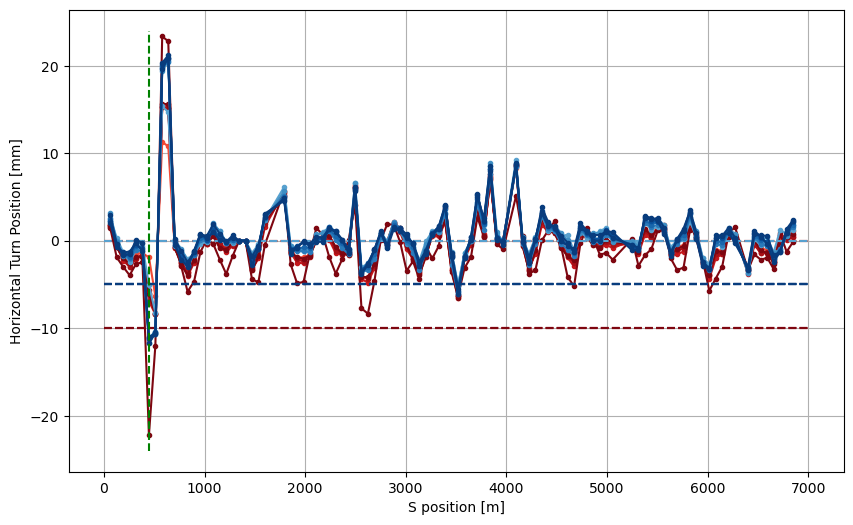

In [152]:
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

def truncate_colormap(cmap, minval=0.4, maxval=0.95, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

cases = {
    datetime(2025, 4, 30, 14, 59, 42): ['betatron', 0],
    datetime(2025, 4, 30, 15, 0, 37): ['betatron', -0.005],
    datetime(2025, 4, 30, 15, 1, 5): ['betatron', -0.01],
    datetime(2025, 4, 30, 15, 1, 32): ['betatron', 0.0],
    datetime(2025, 4, 30, 15, 2, 0): ['betatron', -0.01],
    datetime(2025, 4, 30, 15, 2, 27): ['betatron', -0.01],
    datetime(2025, 4, 30, 15, 7, 4): ['rs', 0.0],
    datetime(2025, 4, 30, 15, 8, 39): ['rs', -0.005],
    datetime(2025, 4, 30, 15, 8, 54): ['rs', -0.005],
    datetime(2025, 4, 30, 15, 9, 21): ['rs', -0.005],
    datetime(2025, 4, 30, 15, 10, 16): ['rs', -0.005],
    datetime(2025, 4, 30, 15, 12, 7): ['rs', -0.005],
    datetime(2025, 4, 30, 15, 12, 34): ['rs', -0.005]
}
s_tidp = line.get_s_position('tidp.11434')

cmap_betatron = truncate_colormap(plt.get_cmap('Reds'), 0.4, 0.95)
cmap_radial_steering = truncate_colormap(plt.get_cmap('Blues'), 0.4, 0.95)
norm_b = colors.Normalize(vmin=0, vmax=6)
norm_rs = colors.Normalize(vmin=0, vmax=7)

fig, ax = plt.subplots(figsize=(10, 6))
b = 2
rs = 2
for ts in cases:
    if ts in bpm_dict:
        if cases[ts][0]=='betatron':
            color = cmap_betatron(norm_b(b))
            b+=1
        else:
            color = cmap_radial_steering(norm_rs(rs))
            rs+=1
        ax.plot(s_positions_bpms[:-1], bpm_dict[ts].hor_turn_position[:-1]*1e-3, marker='o', markersize=3, linestyle='-', color=color)
        #ax.scatter(s_tidp, cases[ts][1]*1e3, color=color, marker='o', s=100)
        ax.hlines(cases[ts][1]*1e3, 0, 7000, color=color, linestyle='--')
ax.vlines(s_tidp, -24, 24, color='green', linestyle='--', label='TIDP position')
ax.grid()
ax.set_xlabel('S position [m]')
ax.set_ylabel('Horizontal Turn Position [mm]')

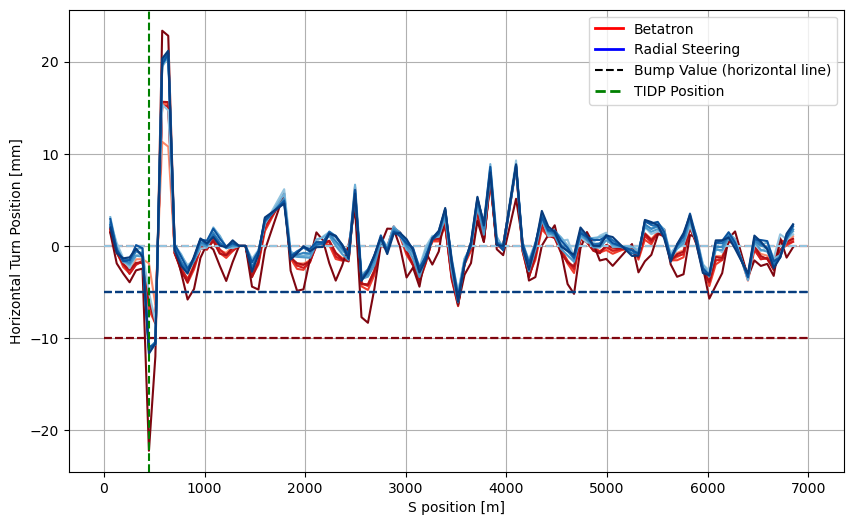

In [160]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Truncate colormap to remove pale colors
def truncate_colormap(cmap, minval=0.4, maxval=0.95, n=100):
    return LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )

# Custom colormaps
cmap_betatron = truncate_colormap(plt.get_cmap('Reds'), 0.4, 0.95)
cmap_radial_steering = truncate_colormap(plt.get_cmap('Blues'), 0.4, 0.95)

# Your plot
fig, ax = plt.subplots(figsize=(10, 6))
b = 0
rs = 0

# Determine number of each case for coloring
n_betatron = sum(1 for ts in cases if ts in bpm_dict and cases[ts][0] == 'betatron')
n_radial = sum(1 for ts in cases if ts in bpm_dict and cases[ts][0] != 'betatron')
betatron_colors = np.linspace(0, 1, n_betatron)
radial_colors = np.linspace(0, 1, n_radial)

for ts in cases:
    if ts in bpm_dict:
        if cases[ts][0] == 'betatron':
            color = cmap_betatron(betatron_colors[b])
            b += 1
        else:
            color = cmap_radial_steering(radial_colors[rs])
            rs += 1
        ax.plot(s_positions_bpms[:-1], bpm_dict[ts].hor_turn_position[:-1]*1e-3,
                 markersize=3, linestyle='-', color=color)

        ax.hlines(cases[ts][1]*1e3, 0, 7000, color=color, linestyle='--')

# Optional: draw the vertical green line at TIDP
ax.axvline(x=s_tidp, color='green', linestyle='--')

# Labels
ax.grid()
ax.set_xlabel('S position [m]')
ax.set_ylabel('Horizontal Turn Position [mm]')

# Legend handles
legend_handles = [
    Line2D([0], [0], color='red', lw=2, label='Betatron'),
    Line2D([0], [0], color='blue', lw=2, label='Radial Steering'),
    Line2D([0], [0], color='black', linestyle='--', label='Bump Value (horizontal line)'),
    Line2D([0], [0], color='green', linestyle='--', lw=2, label='TIDP Position')
]

ax.legend(handles=legend_handles, loc='best')


# MD 16/06/2025

Hannes said that the weird region close to 3000m is probably bpms not working thus being noise. TO BE CHECKED


Not the same in simulation because we do not have the same closed orbit. So first thing could be to find a closed orbit without radial steering in the data, subtract it to the one with radial steering and see if it gets closer to the xsuite one.


Better is to try to match xsuite model with bpm readings we have, then apply bump as in machine MD, and then steer and compare.


Bump can be not the same because we changed the tune and the chroma so calculation is done for the "standard tune". Then it can be that the bump is not the same. This would also be the case in the machine...

## Bump check

Inconclusive: if I change the tune in the line, it still gives the bump too low. If I calculate the bump with changed tune, it gives the same as without the change

In [ ]:
# Line 3 
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
line['bump.11207'] = 1.19603e-4
line['bump.11407'] = -9.3027e-5
line['bump.11607'] = 1.19603e-4

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']

line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

tw = line.twiss()

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


In [ ]:
# Line 3 
line2 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
tw_ref4d = line2.twiss4d()
tw_ref = line2.twiss()
line2['bump.11207'] = 0
line2['bump.11407'] = 0
line2['bump.11607'] = 0

line2.ref['mdh.11207'].knl[0] += line2.vars['bump.11207']
line2.ref['mdh.11407'].knl[0] += line2.vars['bump.11407']
line2.ref['mdh.11607'].knl[0] += line2.vars['bump.11607']

line2.vars['qph_setvalue'] = 0.5
line2.vars['qpv_setvalue'] = 0.5
line2.vars['qh_setvalue'] = line2.vars['qx0']._value + 0.05
line2.vars['qv_setvalue'] = line2.vars['qy0']._value + 0.05

opt = line2.match(
    solve=False,
    start='mdh.11007',
    end='mdhw.11732',
    init=tw_ref,
    vary=[
        xt.VaryList(['bump.11207', 'bump.11407', 'bump.11607'], step=1e-8, tag='bump',)
    ],
    targets = [
        xt.Target('x', -10e-3, at='tidp.11434'),
        xt.TargetSet(['x', 'px'], value=tw_ref, at='mdhw.11732')
    ]
    )
opt.run_jacobian(10)
tw2 = line2.twiss()

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           
                                             
Optimize - start penalty: 0.09974                           
Matching: model call n. 11 penalty = 3.8912e-09              
Optimize - end penalty:  3.89121e-09                            


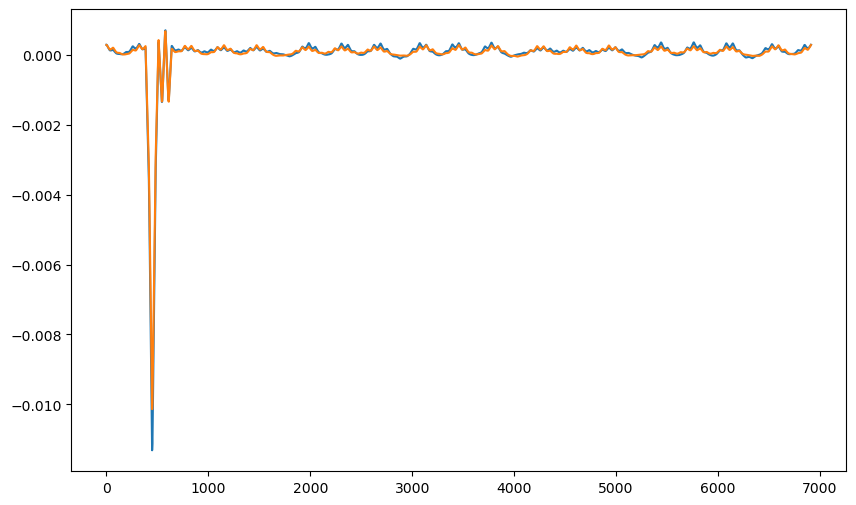

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tw.s, tw.x)
ax.plot(tw2.s, tw2.x, label='Bump off')

## Checking BPMs in weird zone to see if it is sextant 3 that is bugging

In [162]:
from zoneinfo import ZoneInfo
from datetime import datetime, timedelta

In [163]:
directory = Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2')
paths_files_list = list(directory.glob("*.parquet"))
path_files = {}
for path in paths_files_list:
    stem = path.stem
    dt = datetime.strptime(stem, "%Y.%m.%d.%H.%M.%S.%f")
    dt = dt.replace(tzinfo=ZoneInfo("Europe/Paris"))
    path_files[dt] = path
path_files = pd.DataFrame.from_dict(path_files, orient='index', columns=['path'])
path_files.index = pd.to_datetime(path_files.index)
print(path_files.index.is_monotonic_increasing)
path_files = path_files.sort_index() #Files need to be sorted by index for correct time series handling
print(path_files.index.is_monotonic_increasing)

False
True


In [165]:
df_params = pd.read_json('../../MD_data/20250616/parameters.json').T
df_params.index = pd.to_datetime(df_params.index) #convert index (string timestamp) to datetime
df_params.index = df_params.index.tz_localize("Europe/Paris") #Set to Geneva time
changes_ts = df_params.index.to_numpy()

df_fo = pd.read_json('../../MD_data/20250616/full_overview.json').T
df_fo.index = pd.to_datetime(df_fo.index) #convert index (string timestamp) to datetime
df_fo.index = df_fo.index.tz_localize("Europe/Paris") #Set to Geneva time

# Making new dict with paths per timestamp
paths_per_ts = {}
dt = timedelta(seconds=1)
for ts_start, ts_end in zip(changes_ts[:-1], changes_ts[1:]):
    ll = df_fo.loc[ts_start:ts_end-dt].index.to_numpy()
    lll = path_files.loc[ts_start:ts_end-dt, "path"].to_numpy()
    
    for i in range(len(ll)):
        paths_per_ts[ll[i]] = lll[i]
paths_per_ts = pd.DataFrame.from_dict(paths_per_ts, orient='index', columns=['path'])

In [ ]:
# Loading data 
selected_ts = paths_per_ts.loc["2025-06-16 20:04:11":"2025-06-16 20:05:33"].index.to_numpy()
selected_paths = paths_per_ts.loc["2025-06-16 20:04:11":"2025-06-16 20:05:33", "path"].to_numpy()

bpm_dict = {}
for i,path in enumerate(selected_paths):
    bpm_dict[selected_ts[i]] = ak.Array(ak.from_parquet(path), with_name="BPMCollection")

hor_turn_position = bpm_dict[selected_ts[0]].hor_turn_position
s_pos = line.get_s_position([f'{bpm}..0' for bpm in bpm_dict[selected_ts[0]].bpms_hor if f'{bpm}..0' in line.element_names])

In [176]:
np.where(bpm_dict[selected_ts[0]].bpms_hor[:,:6]=='bph.3')

(<Array [] type='0 * int64'>,)

In [177]:
s_positions_bpms = np.array([line.get_s_position(f'{bpm}..0') for bpm in bpm_dict[selected_ts[0]].bpms_hor if f'{bpm}..0' in line.element_names])

In [179]:
len(s_positions_bpms)

102

In [183]:
mask = (s_positions_bpms >= 2500) & (s_positions_bpms <= 3500)

In [ ]:
s_positions_bpms[mask], bpm_dict[selected_ts[0]].bpms_hor[mask]

(array([2559.4462, 2623.4416, 2687.437 , 2751.4325, 2815.4279, 2879.4233,
        2943.4187, 3007.4141, 3071.4095, 3135.4049, 3199.4003, 3263.3957,
        3327.3911, 3391.3865, 3455.3819]),
 <Array ['bph.30808', 'bph.31008', ..., 'bph.33608'] type='15 * string'>)

In [187]:
for name in bpm_dict[selected_ts[0]].bpms_hor[mask]:
    print(name)

bph.30808
bph.31008
bph.31208
bph.31408
bph.31608
bph.31808
bph.32008
bph.32208
bph.32408
bph.32608
bph.32808
bph.33008
bph.33208
bph.33408
bph.33608


They are all in sextant 3, so they are probably just not working and have to be discarded from analysis

## Finding a non-radial steering orbit

In [191]:
selected_ts = paths_per_ts.loc["2025-06-16 17:48:00":"2025-06-16 19:00:00"].index.to_numpy()
selected_paths = paths_per_ts.loc["2025-06-16 17:48:00":"2025-06-16 19:00:00", "path"].to_numpy()

bpm_dict = {}
for i,path in enumerate(selected_paths):
    bpm_dict[selected_ts[i]] = ak.Array(ak.from_parquet(path), with_name="BPMCollection")

In [202]:
import os
import glob
from datetime import datetime
import pandas as pd

def select_parquet_files_by_timestamp(directory, start_time, end_time):
    """
    Select .parquet files with timestamps within a given datetime range.

    Parameters:
    - directory (str): Path to directory containing .parquet files.
    - start_time (datetime): Start of timestamp range.
    - end_time (datetime): End of timestamp range.

    Returns:
    - pandas.DataFrame with columns ['timestamp', 'path']
    """
    parquet_files = glob.glob(os.path.join(directory, '*.parquet'))

    data = []
    for file_path in parquet_files:
        filename = os.path.basename(file_path)
        timestamp_str = filename.replace('.parquet', '')
        try:
            timestamp = datetime.strptime(timestamp_str, "%Y.%m.%d.%H.%M.%S.%f")
        except ValueError:
            continue  # Skip malformed filenames

        if start_time <= timestamp <= end_time:
            data.append((timestamp, file_path))

    df = pd.DataFrame(data, columns=["timestamp", "path"])
    return df.sort_values(by="timestamp").reset_index(drop=True)


In [210]:
start = datetime(2025, 6, 16, 17, 48, 0)
end = datetime(2025, 6, 16, 19, 0, 0)

dir_path = Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2')
timestamps_df = select_parquet_files_by_timestamp(dir_path, start, end)
timestamps_df['timestamp'] = pd.to_datetime(timestamps_df['timestamp'])
timestamps_df['timestamp'] = timestamps_df['timestamp'].dt.tz_localize('Europe/Paris')

ts_array = timestamps_df['timestamp'].to_numpy()

In [208]:
bpm_dict = {}
for ts in timestamps_df['timestamp']:
    bpm_dict[ts] = ak.Array(ak.from_parquet(timestamps_df[timestamps_df['timestamp'] == ts]['path'].values[0]), with_name="BPMCollection")

In [229]:
# mean orbit over postmortem
means = ak.Array([ak.mean(bpm_dict[ts].hor_turn_position, axis=1) for ts in ts_array])

In [241]:
bpm_dict[ts_array[0]].hor_turn_position

<Array [[-24.6, -25.2, ..., -25.5, -25.3], ...] type='102 * var * ?float64'>

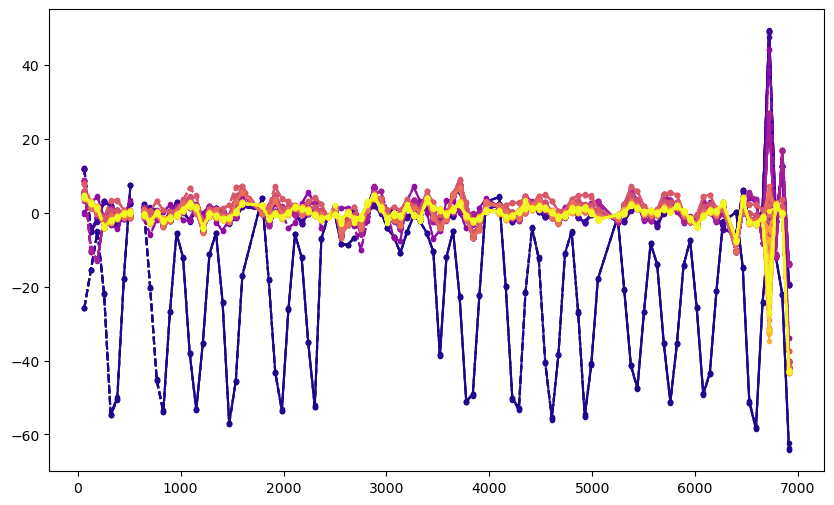

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
s_positions_bpms = np.array([line.get_s_position(f'{bpm}..0') for bpm in bpm_dict[selected_ts[0]].bpms_hor])
cmap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=0, vmax=len(ts_array)-1)
for i, ts in enumerate(ts_array):
    if i >0:# len(ts_array) - 1:
        ax.plot(s_positions_bpms, means[i], color=cmap(norm(i)), marker='.', ls='--')
        #ax.plot(means[i], color=cmap(norm(i)), lw=1)

In [284]:
bpm_dict[ts_array[0]].bpms_hor[8], bpm_dict[ts_array[0]].hor_turn_position[8]

('bph.11831',
 <Array [None, None, None, None, ..., None, None, None] type='1024 * ?float64'>)

The hole in the plot comes from the fact that bph.11831 does not give any value and seems broken. I just interpolate the data here linearly, as it should do the same as removing the bpm from the list

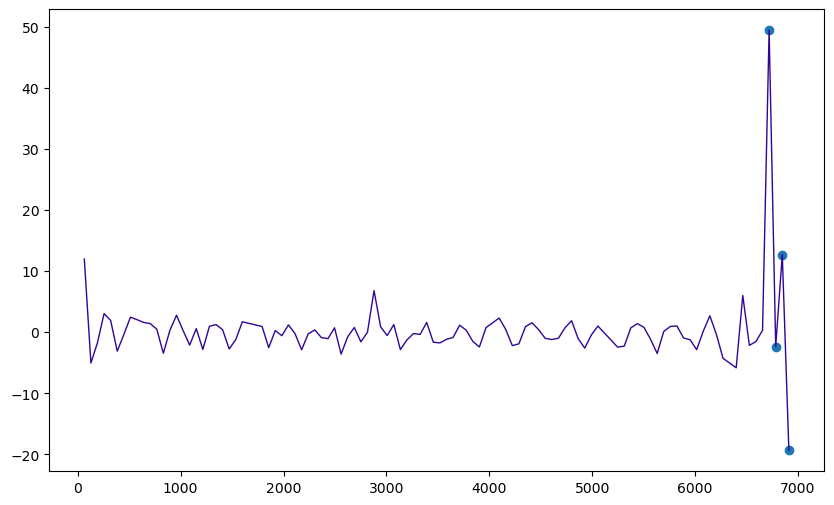

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

cmap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=1, vmax=len(means))
for i, ts in enumerate(ts_array):
    if i > 4:
        y_interp = pd.Series(means[i]).interpolate(method='polynomial', order=1).to_numpy()
        ax.plot(s_positions_bpms, y_interp, color=cmap(norm(i)), lw=1)
        ax.scatter(s_positions_bpms[98:], y_interp[98:])

In [299]:
len(ts_array)

125

### Analysis bpm offset
The last 4 BPMs seem off (maybe not the third last), so let's see if they fall into an interval in most of the fills

In [322]:
faulty_bpms = {}
faulty_bpms_nn = {}
tot = len(ts_array) - 5
for i in range(5,len(ts_array)):
    m = ak.nanmean(means[i])
    std = ak.nanstd(means[i])
    ll = np.where(np.abs(means[i]) > (m + std))[0]
    for nn in ll:
        bb = bpm_dict[ts_array[i]].bpms_hor[nn]
        if bb not in faulty_bpms:
            faulty_bpms[bb] = 1
            faulty_bpms_nn[bb] = [nn]
        else:
            faulty_bpms[bb] += 1
for key in faulty_bpms:
    faulty_bpms[key] /= tot/100

In [323]:
faulty_bpms

{'bph.10208': 64.16666666666667,
 'bph.31808': 52.5,
 'bph.63008': 74.16666666666667,
 'bph.63408': 15.833333333333334,
 'bph.63608': 90.83333333333334,
 'bph.62208': 2.5,
 'bph.20208': 28.333333333333336,
 'bph.21408': 43.333333333333336,
 'bph.30808': 30.833333333333336,
 'bph.40608': 25.833333333333336,
 'bph.40808': 43.333333333333336,
 'bph.41208': 40.0,
 'bph.62008': 84.16666666666667,
 'bph.31408': 15.0,
 'bph.41408': 10.833333333333334,
 'bph.30408': 3.3333333333333335,
 'bph.32408': 1.6666666666666667,
 'bph.32608': 1.6666666666666667,
 'bph.33008': 1.6666666666666667,
 'bph.33608': 1.6666666666666667,
 'bph.62808': 9.166666666666668,
 'bph.10408': 7.5,
 'bph.10608': 7.5,
 'bph.32008': 2.5,
 'bph.52408': 10.833333333333334,
 'bph.62408': 6.666666666666667,
 'bph.63208': 7.5,
 'bph.53408': 1.6666666666666667,
 'bph.13408': 2.5,
 'bph.21208': 3.3333333333333335,
 'bph.22408': 3.3333333333333335}

In [379]:
bpm_dict[ts_array[0]].bpms_hor[8], bpm_dict[ts_array[0]].hor_turn_position[8]

('bph.11831',
 <Array [None, None, None, None, ..., None, None, None] type='1024 * ?float64'>)

Based on this I would exclude all BPMs that look faulty more than 50% of the time, so:

- bph.10208
- bph.31808
- bph.63008
- bph.63608
- bph.62008

Here bph.11831 always gives None values

In [380]:
mask_bpm = np.array([True if bpm not in ['bph.10208', 'bph.31808', 'bph.63008', 'bph.63608', 'bph.62008', 'bph.11831'] else False for bpm in bpm_dict[ts_array[0]].bpms_hor])

Text(0, 0.5, 'Horizontal Turn Position [mm]')

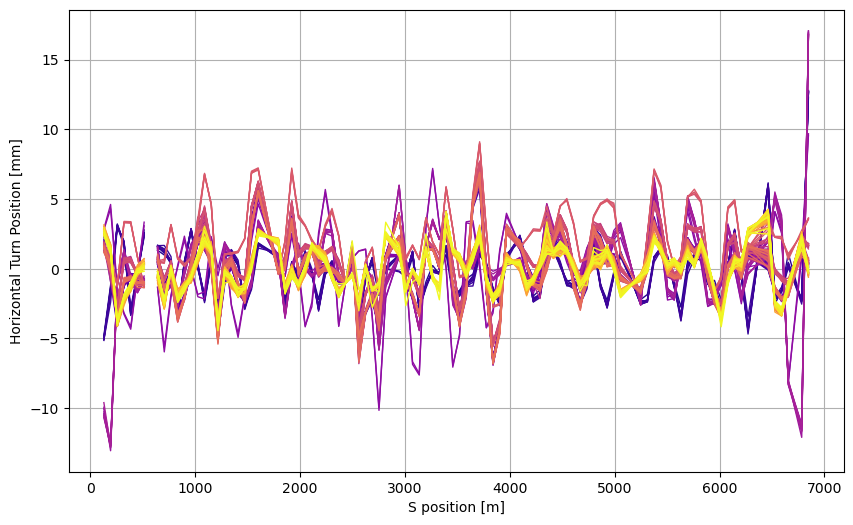

In [329]:
fig, ax = plt.subplots(figsize=(10, 6))
#s_positions_bpms = np.array([line.get_s_position(f'{bpm}..0') for bpm in bpm_dict[selected_ts[0]].bpms_hor])
cmap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=0, vmax=len(ts_array)-1)
for i in range(5, len(ts_array)):
    ax.plot(s_positions_bpms[mask_bpm], means[i][mask_bpm], color=cmap(norm(i)), lw=1)
ax.grid()
ax.set_xlabel('S position [m]')
ax.set_ylabel('Horizontal Turn Position [mm]')

From this we can take a mean orbit, assuming it looked like this in the machine, or we just take one of the earlier ones because that would be the corrected orbit before we started trying to put the bump in. Actually, this might be a better option. Go two subtitles down for it

## Check if we can see the bump individually

I will just take one file with -20mm bump that should be very visible

In [285]:
test_file = ak.Array(ak.from_parquet('../../MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.19.27.32.216367.parquet'), with_name="BPMCollection")

In [287]:
m = ak.mean(test_file.hor_turn_position, axis=1)

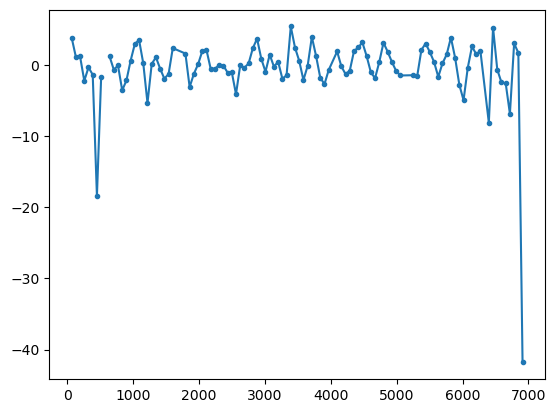

In [290]:
plt.plot(s_positions_bpms, m, marker='.')

Bump is clearly visible and looks almost too high, would be good to do thorough analysis as to if it matches what we asked or not

## Defining a 'clean' reference orbit

Text(0, 0.5, 'Horizontal Turn Position [mm]')

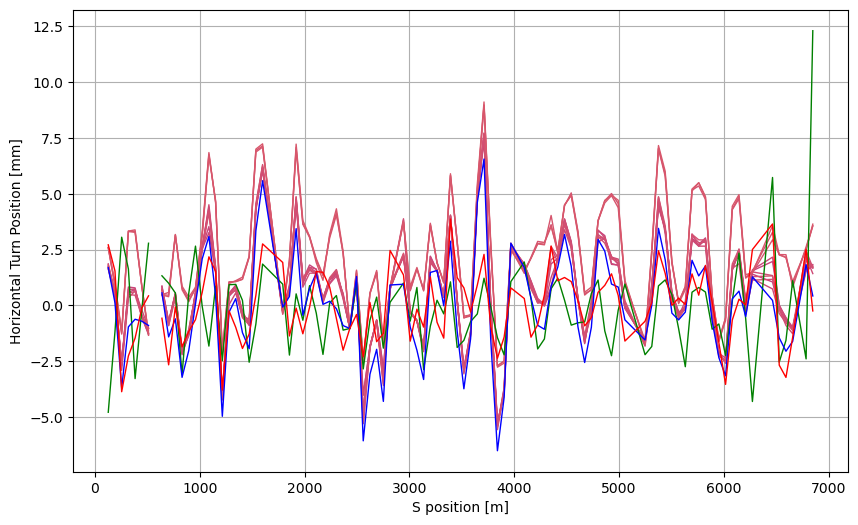

In [378]:
fig, ax = plt.subplots(figsize=(10, 6))
#s_positions_bpms = np.array([line.get_s_position(f'{bpm}..0') for bpm in bpm_dict[selected_ts[0]].bpms_hor])
cmap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=0, vmax=len(ts_array)-1)
for i in range(60, 70):
    ax.plot(s_positions_bpms[mask_bpm], means[i][mask_bpm], color=cmap(norm(i)), lw=1)
ax.plot(s_positions_bpms[mask_bpm], means[5][mask_bpm], color='green', lw=1)
ax.plot(s_positions_bpms[mask_bpm], means[13][mask_bpm], color='blue', lw=1)
ax.plot(s_positions_bpms[mask_bpm], means[100][mask_bpm], color='red', lw=1)
ax.grid()
ax.set_xlabel('S position [m]')
ax.set_ylabel('Horizontal Turn Position [mm]')

In [369]:
len(ts_array)

125

red one seems pretty stable, otherwise I take a mean of everything

## Subtracting to radial steering

In [381]:
orbit_hor = means[100][mask_bpm]

In [382]:
directory = Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2')
paths_files_list = list(directory.glob("*.parquet"))
path_files = {}
for path in paths_files_list:
    stem = path.stem
    dt = datetime.strptime(stem, "%Y.%m.%d.%H.%M.%S.%f")
    dt = dt.replace(tzinfo=ZoneInfo("Europe/Paris"))
    path_files[dt] = path
path_files = pd.DataFrame.from_dict(path_files, orient='index', columns=['path'])
path_files.index = pd.to_datetime(path_files.index)
print(path_files.index.is_monotonic_increasing)
path_files = path_files.sort_index() #Files need to be sorted by index for correct time series handling
print(path_files.index.is_monotonic_increasing)

False
True


In [383]:
df_params = pd.read_json('../../MD_data/20250616/parameters.json').T
df_params.index = pd.to_datetime(df_params.index) #convert index (string timestamp) to datetime
df_params.index = df_params.index.tz_localize("Europe/Paris") #Set to Geneva time
changes_ts = df_params.index.to_numpy()

df_fo = pd.read_json('../../MD_data/20250616/full_overview.json').T
df_fo.index = pd.to_datetime(df_fo.index) #convert index (string timestamp) to datetime
df_fo.index = df_fo.index.tz_localize("Europe/Paris") #Set to Geneva time

# Making new dict with paths per timestamp
paths_per_ts = {}
dt = timedelta(seconds=1)
for ts_start, ts_end in zip(changes_ts[:-1], changes_ts[1:]):
    ll = df_fo.loc[ts_start:ts_end-dt].index.to_numpy()
    lll = path_files.loc[ts_start:ts_end-dt, "path"].to_numpy()
    
    for i in range(len(ll)):
        paths_per_ts[ll[i]] = lll[i]
paths_per_ts = pd.DataFrame.from_dict(paths_per_ts, orient='index', columns=['path'])

In [384]:
# Loading data 
selected_ts = paths_per_ts.loc["2025-06-16 20:04:11":"2025-06-16 20:05:33"].index.to_numpy()
selected_paths = paths_per_ts.loc["2025-06-16 20:04:11":"2025-06-16 20:05:33", "path"].to_numpy()

bpm_dict = {}
for i,path in enumerate(selected_paths):
    bpm_dict[selected_ts[i]] = ak.Array(ak.from_parquet(path), with_name="BPMCollection")

hor_turn_position = bpm_dict[selected_ts[0]].hor_turn_position
s_pos = line.get_s_position([f'{bpm}..0' for bpm in bpm_dict[selected_ts[0]].bpms_hor if f'{bpm}..0' in line.element_names])

In [394]:
selected_ts

array([Timestamp('2025-06-16 20:04:11.900000+0200', tz='Europe/Paris'),
       Timestamp('2025-06-16 20:04:39.500000+0200', tz='Europe/Paris'),
       Timestamp('2025-06-16 20:05:07.100000+0200', tz='Europe/Paris')],
      dtype=object)

In [405]:
hor_turn_position[mask_bpm][:,0]

<Array [-8.34, -1.75, -17.2, -36, ..., -17.5, -5.11, -26] type='96 * ?float64'>

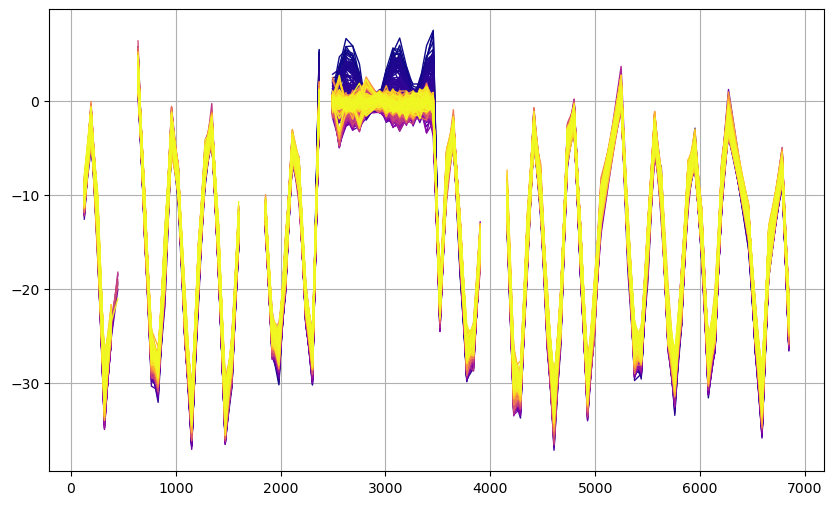

In [409]:
fig, ax = plt.subplots(figsize=(10, 6))
cmap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=0, vmax=1024)

for i in range(1024):
    ax.plot(s_positions_bpms[mask_bpm], hor_turn_position[mask_bpm][:,i]-orbit_hor, color=cmap(norm(i)), lw=1)
ax.grid()

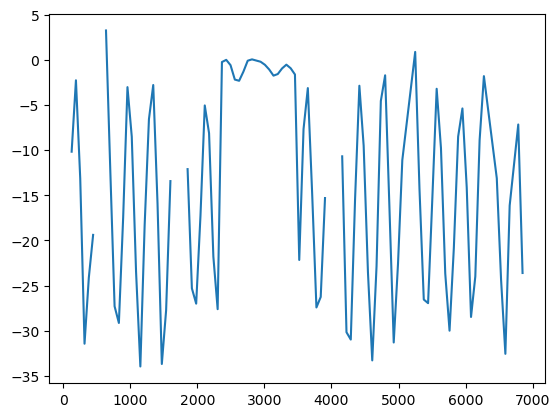

In [412]:
plt.plot(s_positions_bpms[mask_bpm], ak.mean(hor_turn_position[mask_bpm]-orbit_hor, axis=1))

This looks still less shifted than the simulation, so probably the delta is less. I can do a twiss to get the delta that would match this orbit shift, and then compare with simulation, which is already a good approx, but the next step is to match the xsuite orbit with what it was during the MD. This gives probably the best orbit... But not today, too late now